# Initialize Notebook
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/00


In [2]:
sys.path.append("../")
import plotParameters

# Load Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [3]:
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
file_input_name = '../runs/calibration/calibration.root'
# file_input_name = '../runs/output_NEST_e-_1MeV.root'
# file_input_name = '../build/event_total.root'
# file_input_name = '../build/event.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = [name for name in file_input_uproot.keys() if "/photoSensor_" in name]
print(histogram_names)

histogram_titles = [file_input_pyroot.Get(name).GetTitle() for name in histogram_names]
print(histogram_titles)

histogram_positions = [(float(title.split('_')[2]), float(title.split('_')[3]), float(title.split('_')[4])) for title in histogram_titles]
print(histogram_positions)

tree_names = [name for name in file_input_uproot.keys() if histogram_directory not in name]
print(tree_names)

['photoSensor_hits_histograms/photoSensor_0;1', 'photoSensor_hits_histograms/photoSensor_1;1', 'photoSensor_hits_histograms/photoSensor_2;1', 'photoSensor_hits_histograms/photoSensor_3;1', 'photoSensor_hits_histograms/photoSensor_4;1', 'photoSensor_hits_histograms/photoSensor_5;1', 'photoSensor_hits_histograms/photoSensor_6;1', 'photoSensor_hits_histograms/photoSensor_7;1', 'photoSensor_hits_histograms/photoSensor_8;1', 'photoSensor_hits_histograms/photoSensor_9;1', 'photoSensor_hits_histograms/photoSensor_10;1', 'photoSensor_hits_histograms/photoSensor_11;1', 'photoSensor_hits_histograms/photoSensor_12;1', 'photoSensor_hits_histograms/photoSensor_13;1', 'photoSensor_hits_histograms/photoSensor_14;1', 'photoSensor_hits_histograms/photoSensor_15;1', 'photoSensor_hits_histograms/photoSensor_16;1', 'photoSensor_hits_histograms/photoSensor_17;1', 'photoSensor_hits_histograms/photoSensor_18;1', 'photoSensor_hits_histograms/photoSensor_19;1', 'photoSensor_hits_histograms/photoSensor_20;1', '

In [4]:
hits_list_library = {}
hits_hist_library = {}
for name in tqdm.tqdm(histogram_names):
    # Get the histogram from the ROOT file
    histogram = file_input_pyroot.Get(name)

    # Get the number of bins in the X and Y directions
    n_bins_x = histogram.GetNbinsX() // 4
    n_bins_y = histogram.GetNbinsY() // 4

    # Create NumPy arrays to store the bin contents and edges
    values = np.zeros((n_bins_x, n_bins_y))
    hits = []
    x_edges = []
    y_edges = []

    # Extract the bin contents (values) and edges
    for i in range(1, n_bins_x + 2):
        x_edges.append(histogram.GetXaxis().GetBinLowEdge(i))
    for i in range(1, n_bins_y + 2):
        y_edges.append(histogram.GetYaxis().GetBinLowEdge(i))

    for i in range(n_bins_x):  # Change the range to avoid going out of bounds
        for j in range(n_bins_y):  # Change the range to avoid going out of bounds
            values[i][j] = histogram.GetBinContent(j + 1, i + 1)
            if histogram.GetBinContent(j + 1, i + 1) > 0:
                # Check if edges are within bounds before accessing
                if j < len(y_edges) - 1 and i < len(x_edges) - 1:
                    hits.append(
                        (y_edges[j] + (y_edges[j + 1] - y_edges[j]) / 2, x_edges[i] + (x_edges[i + 1] - x_edges[i]) / 2)
                    )

    # print(name,hits)
    hits_list_library[name] = hits
    hits_hist_library[name] = values

100%|██████████| 600/600 [00:00<00:00, 1184.98it/s]


# Visuliaze Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_13961/1617523827.py:12: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


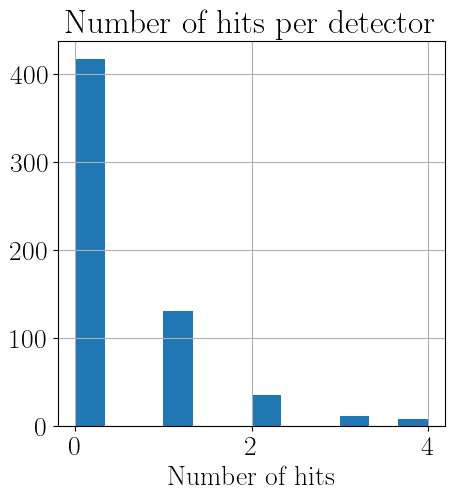

In [5]:
# Find the entry in hits_library with the largest length
# make a list of the index and length
lengths = [(i, len(hits)) for i, hits in enumerate(hits_list_library.values())]
lengths.sort(key=lambda x: x[1])

fig, ax = plt.subplots()
ax.hist([lengths[i][1] for i in range(len(lengths))], bins=12)
ax.set_xlabel("Number of hits")
ax.set_ylabel("")
ax.set_title("Number of hits per detector")
ax.grid()
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_13961/4050348948.py:13: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


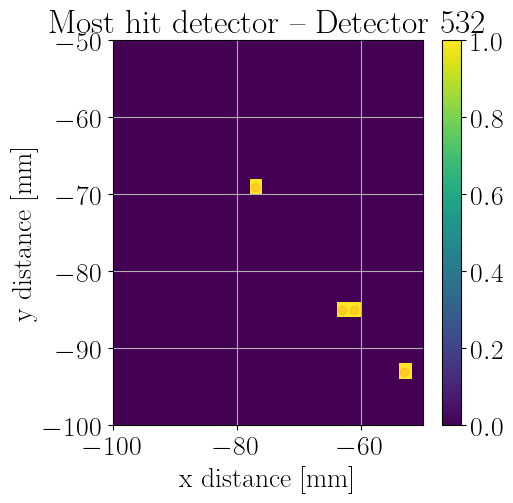

In [6]:
index, length = lengths[-1]
hits = list(hits_list_library.values())[index]
values = list(hits_hist_library.values())[index]

fig, ax = plt.subplots()
im = ax.imshow(values, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), aspect='auto', origin='lower', cmap='viridis')
ax.plot([x[0] for x in hits], [x[1] for x in hits], 'o', alpha=0.1, color='red')
fig.colorbar(im, ax=ax)
ax.set_xlabel("x distance [mm]")
ax.set_ylabel("y distance [mm]")
ax.set_title("Most hit detector -- Detector " + str(index))
ax.grid()
fig.show()

In [7]:
def plot_DSPSs(histograms):
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    for (i, ax), (values, position) in tqdm.tqdm(zip(enumerate(axes.flat), histograms)):
        ax.imshow(values, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), origin='lower', cmap='viridis')
        ax.set_xlabel("")
        ax.set_ylabel("")
        # ax.set_title("{:.1f}, {:.1f}, {:.1f}".format(position[0], position[1], position[2]), fontsize=5)
        ax.set_title("")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid()
    return fig

[-1114.70422  -990.       -770.       -550.       -330.       -110.
   110.        330.        550.        770.        990.       1114.70422]
Z value = -1114.70422


100it [00:00, 2732.75it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_13961/3673718501.py:14: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


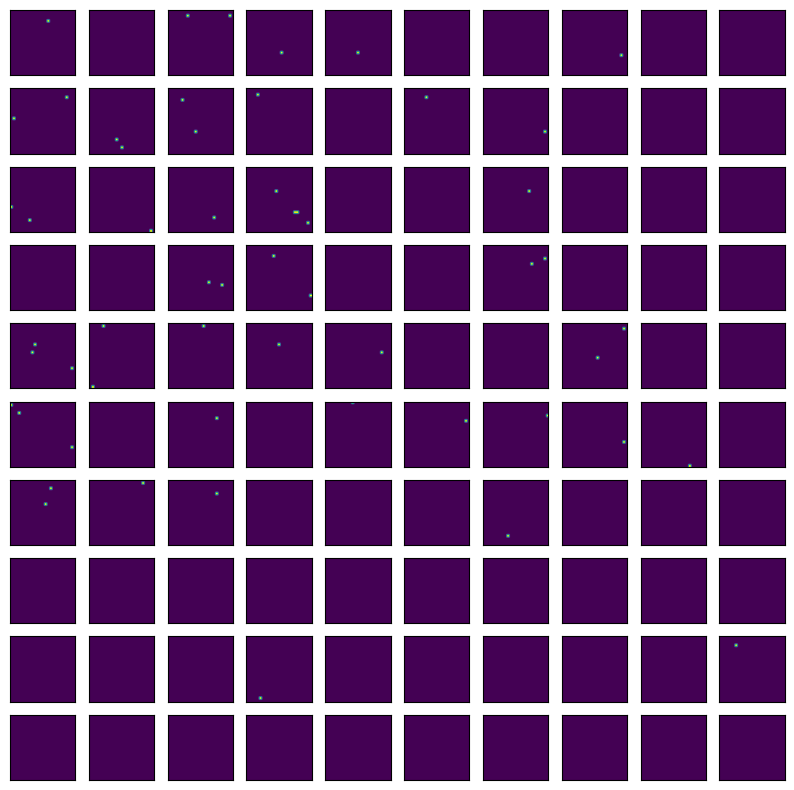

In [8]:
histograms = []
print(np.unique(np.array(histogram_positions)[:, 2]))
z_value = np.unique(np.array(histogram_positions)[:, 2])[0]
print('Z value =', z_value)
for i, position in enumerate(histogram_positions):
    if position[2] == z_value:
        histograms.append((i, position))

histograms.sort(key=lambda hist: (hist[1][1], hist[1][0]))
histograms = [(list(hits_hist_library.values())[i], position) for i, position in histograms]

fig = plot_DSPSs(histograms)
fig.savefig('../figures/preliminaryAnalysis_eventDisplay_-z.pdf', bbox_inches='tight')
fig.show()

[-1114.70422  -990.       -770.       -550.       -330.       -110.
   110.        330.        550.        770.        990.       1114.70422]
Z value = 1114.70422


100it [00:00, 2749.89it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_13961/2734496395.py:14: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


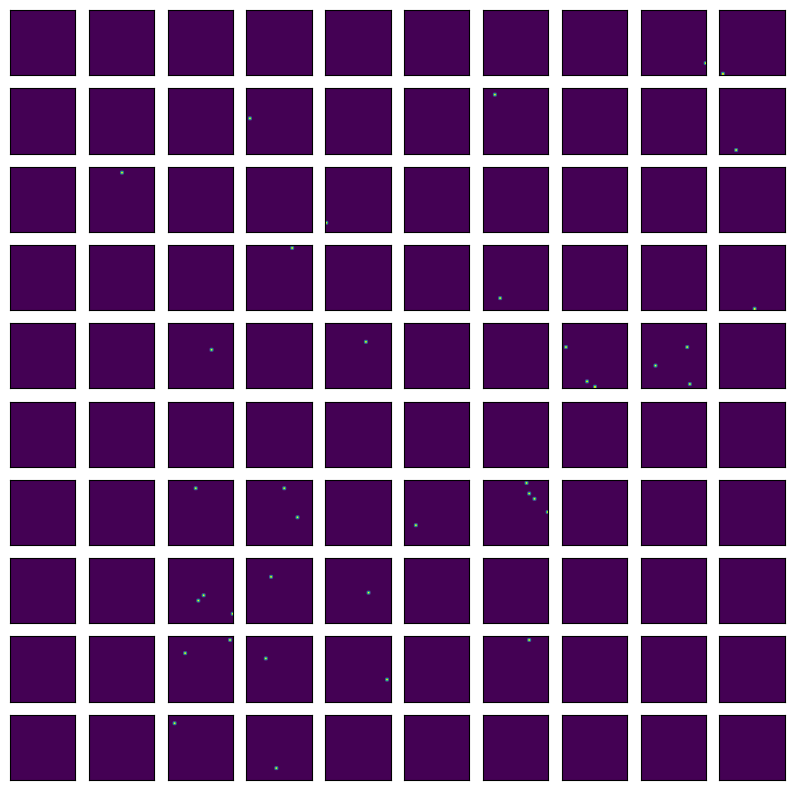

In [9]:
histograms = []
print(np.unique(np.array(histogram_positions)[:, 2]))
z_value = np.unique(np.array(histogram_positions)[:, 2])[-1]
print('Z value =', z_value)
for i, position in enumerate(histogram_positions):
    if position[2] == z_value:
        histograms.append((i, position))

histograms.sort(key=lambda hist: (hist[1][1], hist[1][-1]))
histograms = [(list(hits_hist_library.values())[i], position) for i, position in histograms]

fig = plot_DSPSs(histograms)
fig.savefig('../figures/preliminaryAnalysis_eventDisplay_+z.pdf', bbox_inches='tight')
fig.show()

[-1114.70422  -990.       -770.       -550.       -330.       -110.
   110.        330.        550.        770.        990.       1114.70422]
Y value = -1114.70422


100it [00:00, 2650.56it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_13961/4161432695.py:14: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


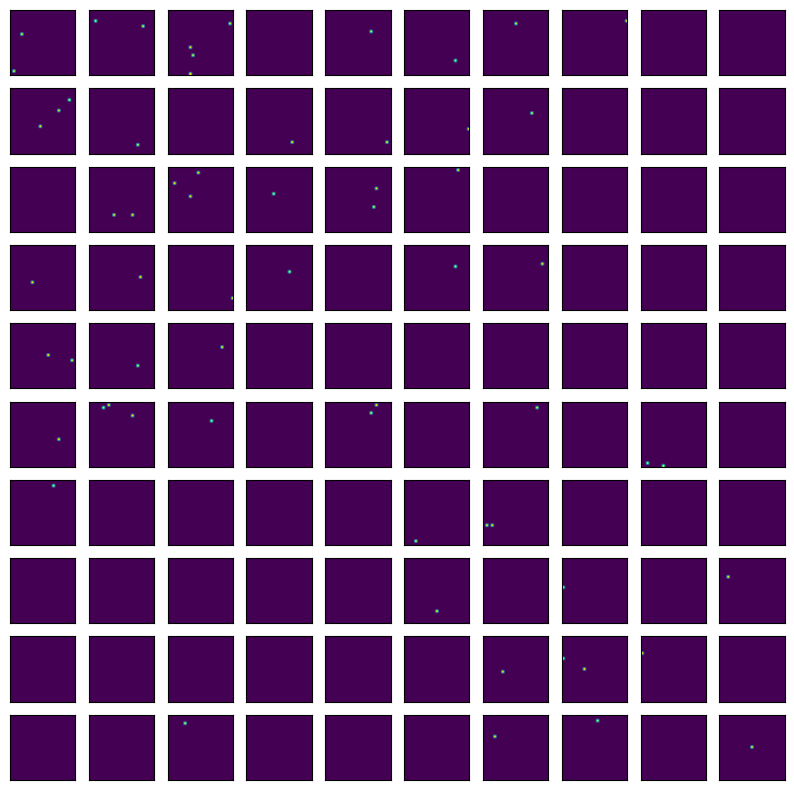

In [10]:
histograms = []
print(np.unique(np.array(histogram_positions)[:, 1]))
y_value = np.unique(np.array(histogram_positions)[:, 1])[0]
print('Y value =', y_value)
for i, position in enumerate(histogram_positions):
    if position[1] == y_value:
        histograms.append((i, position))

histograms.sort(key=lambda hist: (hist[1][2], hist[1][0]))
histograms = [(list(hits_hist_library.values())[i], position) for i, position in histograms]

fig = plot_DSPSs(histograms)
fig.savefig('../figures/preliminaryAnalysis_eventDisplay_-y.pdf', bbox_inches='tight')
fig.show()

[-1114.70422  -990.       -770.       -550.       -330.       -110.
   110.        330.        550.        770.        990.       1114.70422]
Y value = 1114.70422


100it [00:00, 2733.05it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_13961/3250030402.py:14: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


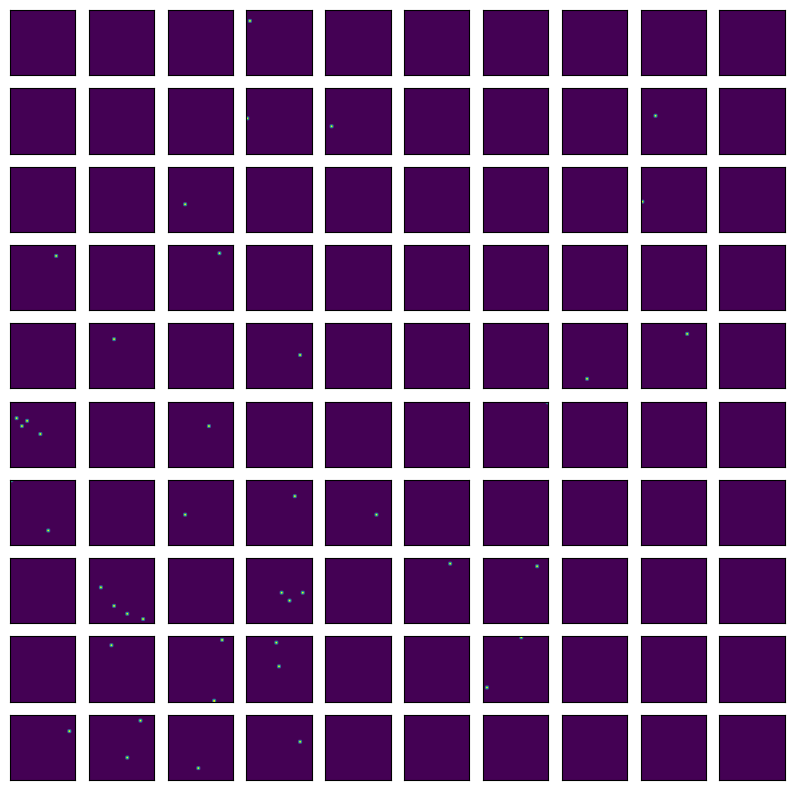

In [11]:
histograms = []
print(np.unique(np.array(histogram_positions)[:, 1]))
y_value = np.unique(np.array(histogram_positions)[:, 1])[-1]
print('Y value =', y_value)
for i, position in enumerate(histogram_positions):
    if position[1] == y_value:
        histograms.append((i, position))

histograms.sort(key=lambda hist: (hist[1][2], hist[1][0]))
histograms = [(list(hits_hist_library.values())[i], position) for i, position in histograms]

fig = plot_DSPSs(histograms)
fig.savefig('../figures/preliminaryAnalysis_eventDisplay_+y.pdf', bbox_inches='tight')
fig.show()

[-1114.70422  -990.       -770.       -550.       -330.       -110.
   110.        330.        550.        770.        990.       1114.70422]
X value = -1114.70422


100it [00:00, 2906.90it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_13961/752119982.py:14: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


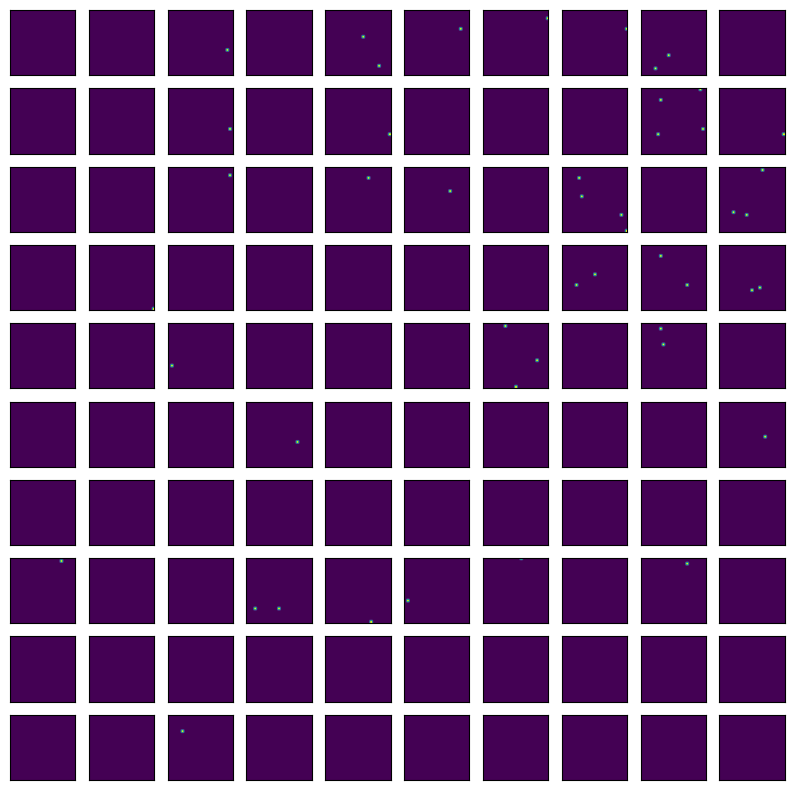

In [12]:
histograms = []
print(np.unique(np.array(histogram_positions)[:, 1]))
x_value = np.unique(np.array(histogram_positions)[:, 0])[0]
print('X value =', x_value)
for i, position in enumerate(histogram_positions):
    if position[0] == x_value:
        histograms.append((i, position))

histograms.sort(key=lambda hist: (hist[1][0], hist[1][1]))
histograms = [(list(hits_hist_library.values())[i], position) for i, position in histograms]

fig = plot_DSPSs(histograms)
fig.savefig('../figures/preliminaryAnalysis_eventDisplay_-x.pdf', bbox_inches='tight')
fig.show()

[-1114.70422  -990.       -770.       -550.       -330.       -110.
   110.        330.        550.        770.        990.       1114.70422]
X value = 1114.70422


100it [00:00, 2297.59it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_13961/3322769001.py:14: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


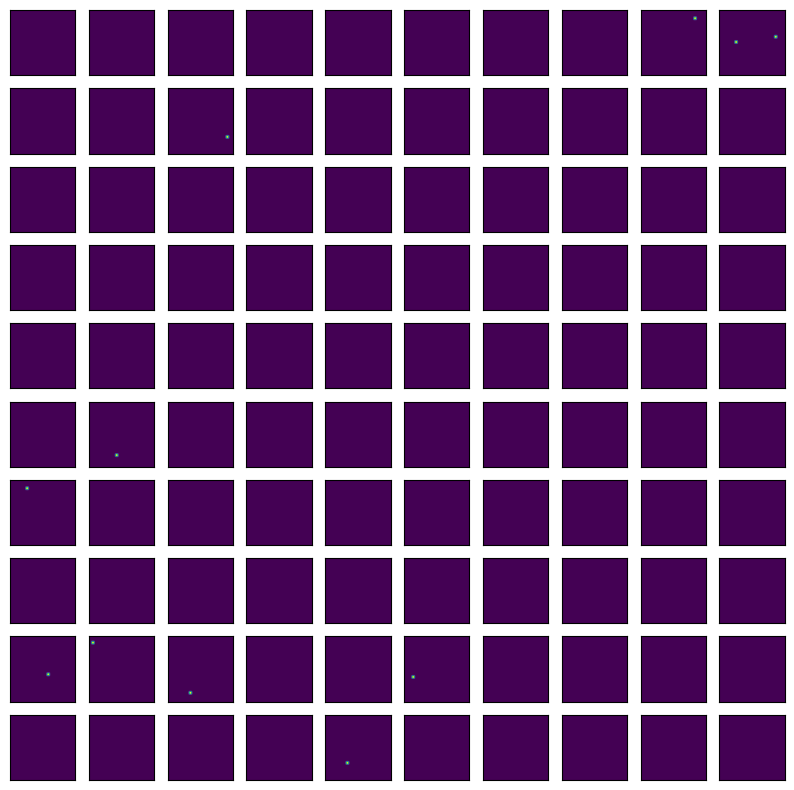

In [13]:
histograms = []
print(np.unique(np.array(histogram_positions)[:, 1]))
x_value = np.unique(np.array(histogram_positions)[:, 0])[-1]
print('X value =', x_value)
for i, position in enumerate(histogram_positions):
    if position[0] == x_value:
        histograms.append((i, position))

histograms.sort(key=lambda hist: (hist[1][0], hist[1][1]))
histograms = [(list(hits_hist_library.values())[i], position) for i, position in histograms]

fig = plot_DSPSs(histograms)
fig.savefig('../figures/preliminaryAnalysis_eventDisplay_+x.pdf', bbox_inches='tight')
fig.show()

In [14]:
# Load the trees from the root file
tree_library = {}
tree_branch_library = {}
branch_data = {}
for name in tqdm.tqdm(tree_names):
    tree_library[name] = file_input_uproot[name]
    tree_branch_library[name] = tree_library[name].keys()
    print(name, tree_branch_library[name])
    for key in tree_branch_library[name]:
        branch_data[key] = tree_library[name][key].array()

  0%|          | 0/3 [00:00<?, ?it/s]

photoSensor_hits;1 ['photoSensor_hits_position_absolute_x', 'photoSensor_hits_position_absolute_y', 'photoSensor_hits_position_absolute_z', 'photoSensor_hits_position_relative_x', 'photoSensor_hits_position_relative_y', 'photoSensor_hits_position_relative_z', 'photoSensor_hits_position_initial_x', 'photoSensor_hits_position_initial_y', 'photoSensor_hits_position_initial_z', 'photoSensor_hits_time', 'photoSensor_hits_process', 'photoSensor_hits_photoSensorID', 'photoSensor_hits_energy']


 33%|███▎      | 1/3 [00:01<00:03,  1.78s/it]

primary;1 ['primary_position_x', 'primary_position_y', 'primary_position_z', 'primary_direction_x', 'primary_direction_y', 'primary_direction_z', 'primary_process', 'primary_time', 'primary_energy', 'primary_volume', 'primary_pdg']
photon;1 ['photon_length', 'photon_process', 'photon_time', 'photon_position_x', 'photon_position_y', 'photon_position_z', 'photon_direction_x', 'photon_direction_y', 'photon_direction_z', 'photon_energy', 'photon_volume']


100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


In [15]:
primary_pdg         = np.array(branch_data['primary_pdg'])
pdg = 13

primary_position_x  = np.array(branch_data['primary_position_x'][primary_pdg == pdg])
primary_position_y  = np.array(branch_data['primary_position_y'][primary_pdg == pdg])
primary_position_z  = np.array(branch_data['primary_position_z'][primary_pdg == pdg])
primary_direction_x = np.array(branch_data['primary_direction_x'][primary_pdg == pdg])
primary_direction_y = np.array(branch_data['primary_direction_y'][primary_pdg == pdg])
primary_direction_z = np.array(branch_data['primary_direction_z'][primary_pdg == pdg])

print('position [ 0] = (',primary_position_x[0], primary_position_y[0], primary_position_z[0],')')
print('direction[ 0] = (',primary_direction_x[0], primary_direction_y[0], primary_direction_z[0],')')
print('position [-1] = (',primary_position_x[-1], primary_position_y[-1], primary_position_z[-1],')')
print('direction[-1] = (',primary_direction_x[-1], primary_direction_y[-1], primary_direction_z[-1],')')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(primary_position_x , primary_position_y , primary_position_z , 
          primary_direction_x, primary_direction_y, primary_direction_z, 
          length=0.1, color='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

100%|██████████| 12/12 [00:00<00:00, 1081.87it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_88721/3738350996.py:31: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


pdg = -11
pdg = 11
pdg = 13
pdg = 14
pdg = 2112
pdg = 1000531260
pdg = 1000541290
pdg = 1000541300
pdg = 1000541304
pdg = 1000541310
pdg = 1000541320
pdg = 1000541340


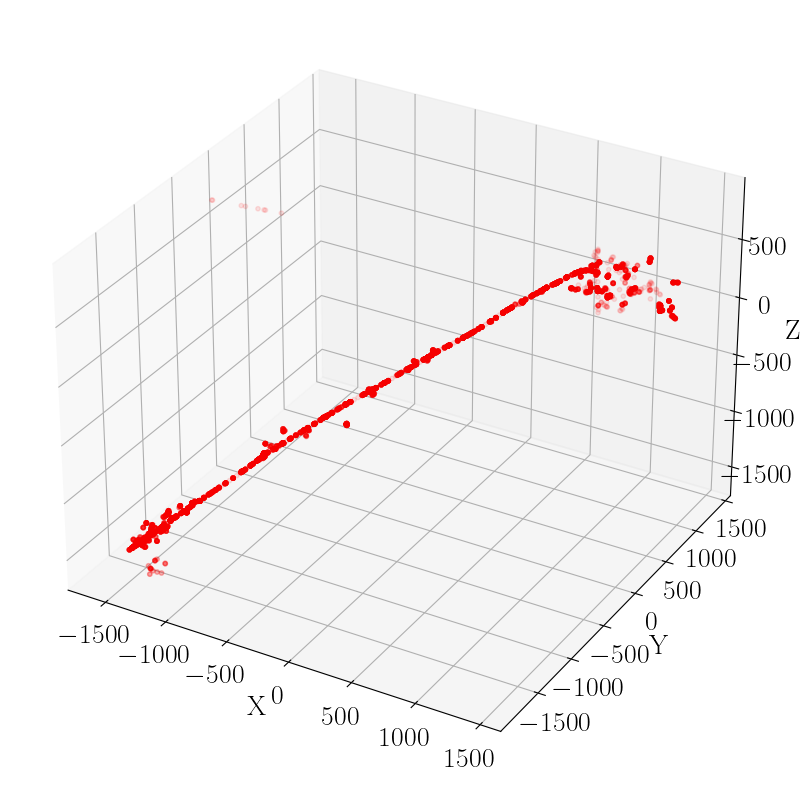

In [ ]:
# %matplotlib qt
# %matplotlib inline

primary_pdg = np.array(branch_data['primary_pdg'])
# pdgs = [13, 11]
pdgs = np.unique(primary_pdg).tolist()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for pdg in tqdm.tqdm(pdgs):
    print('pdg =', pdg)
    primary_position_x  = np.array(branch_data['primary_position_x'])[primary_pdg == pdg]
    primary_position_y  = np.array(branch_data['primary_position_y'])[primary_pdg == pdg]
    primary_position_z  = np.array(branch_data['primary_position_z'])[primary_pdg == pdg]

    # photoSensor_hit_position_initial_x = np.array(branch_data['photoSensor_hits_position_initial_x'])[primary_pdg == pdg]
    # photoSensor_hit_position_initial_y = np.array(branch_data['photoSensor_hits_position_initial_y'])[primary_pdg == pdg]
    # photoSensor_hit_position_initial_z = np.array(branch_data['photoSensor_hits_position_initial_z'])[primary_pdg == pdg]

    ax.scatter(primary_position_x, 
               primary_position_y, 
               primary_position_z, 
               color='red', marker='o', s=10, alpha=0.1)
    # ax.scatter(photoSensor_hit_position_initial_x, 
    #            photoSensor_hit_position_initial_y, 
    #            photoSensor_hit_position_initial_z,
    #            color='blue', marker='x', s=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.show()

In [16]:
# Extract the data for photon_process and photon_volume
photon_process = branch_data['photon_process']
photon_volume = branch_data['photon_volume']

# Make a list of the unique photon_process and photon_volume values
unique_photon_process = np.unique(photon_process)
unique_photon_volume = np.unique(photon_volume)

# Make a dictionary to store the number of photons in each process and volume
photon_process_count = {}
photon_volume_count = {}

# # Loop over the unique photon_process values
# for process in tqdm.tqdm(unique_photon_process):
#     # Get the indices for the current process
#     indices = np.where(photon_process == process)
#     # Store the number of photons in the current process
#     photon_process_count[process] = len(indices[0])

for process in tqdm.tqdm(photon_process):
    if process in photon_process_count:
        photon_process_count[process] += 1
    else:
        photon_process_count[process] = 1

# # Loop over the unique photon_volume values
# for volume in tqdm.tqdm(unique_photon_volume):
#     # Get the indices for the current volume
#     indices = np.where(photon_volume == volume)
#     # Store the number of photons in the current volume
#     photon_volume_count[volume] = len(indices[0])

for volume in tqdm.tqdm(photon_volume):
    if volume in photon_volume_count:
        photon_volume_count[volume] += 1
    else:
        photon_volume_count[volume] = 1

# Print the photon_process_count and photon_volume_count dictionaries
print(photon_process_count)
print(photon_volume_count)

# Combine individualy named volumes into more general volumes
photon_volume_general_count = {}
for volume in tqdm.tqdm(photon_volume_count):
    if 'lensSystem_lens' in volume:
        photon_volume_general_count['lensSystem_lens'] = photon_volume_general_count.get('lensSystem_lens', 0) + photon_volume_count[volume]
    elif 'photoSensor_surface' in volume:
        photon_volume_general_count['photoSensor_surface'] = photon_volume_general_count.get('photoSensor_surface', 0) + photon_volume_count[volume]
    elif 'photoSensor_body' in volume:
        photon_volume_general_count['phototSensor_body'] = photon_volume_general_count.get('phototSensor_body', 0) + photon_volume_count[volume]
    # elif 'calorimeter_horizontal' in volume:
    #     photon_volume_general_count['calorimeter_horizontal'] = photon_volume_general_count.get('calorimeter_horizontal', 0) + photon_volume_count[volume]
    # elif 'calorimeter_vertical' in volume:
    #     photon_volume_general_count['calorimeter_vertical'] = photon_volume_general_count.get('calorimeter_vertical', 0) + photon_volume_count[volume]
    # elif 'calorimeter_middle' in volume:
    #     photon_volume_general_count['calorimeter_middle'] = photon_volume_general_count.get('calorimeter_middle', 0) + photon_volume_count[volume]
    elif 'calorimeter' in volume:
        photon_volume_general_count['calorimeter'] = photon_volume_general_count.get('calorimeter', 0) + photon_volume_count[volume]
    else:
        photon_volume_general_count[volume] = photon_volume_general_count.get(volume, 0) + photon_volume_count[volume]

# Print the photon_volume_general_count dictionary
print(photon_volume_general_count)

100%|██████████| 1053876/1053876 [00:06<00:00, 157406.66it/s]


{'OpAbsorption': 683774, 'Transportation': 370094, 'OpRayleigh': 8}
{'detector_medium': 779908, '/DSPD_+x_1114.704220_-550.000000_330.000000_67_lensSystem_lens_1_preTrim': 64, '/calorimeter_vertical_G4Box': 69544, '/DSPD_-z_-770.000000_330.000000_-1114.704220_16_lensSystem_lens_1_preTrim': 209, '/DSPD_-y_-330.000000_-1114.704220_-550.000000_67_lensSystem_lens_1_preTrim': 207, '/DSPD_-y_-330.000000_-1114.704220_-550.000000_67_lensSystem_lens_0_lens': 52, '/calorimeter_horizontal_G4Box': 69834, '/DSPD_-z_550.000000_-770.000000_-1114.704220_71_lensSystem_lens_1_preTrim': 201, '/DSPD_-y_-110.000000_-1114.704220_-110.000000_55_lensSystem_lens_1_preTrim': 198, '/DSPD_+x_1114.704220_-330.000000_-110.000000_46_lensSystem_lens_1_preTrim': 42, '/DSPD_+y_-330.000000_1114.704220_-550.000000_62_lensSystem_lens_1_preTrim': 218, '/DSPD_+y_-110.000000_1114.704220_-110.000000_54_lensSystem_lens_1_preTrim': 231, '/DSPD_+z_-110.000000_110.000000_1114.704220_54_lensSystem_lens_1_preTrim': 213, '/DSPD_+z_-

100%|██████████| 2322/2322 [00:00<00:00, 3715823.69it/s]


{'detector_medium': 779908, 'lensSystem_lens': 118090, 'calorimeter': 140662, 'photoSensor_surface': 7672, 'phototSensor_body': 7544}


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_13961/1854754086.py:21: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


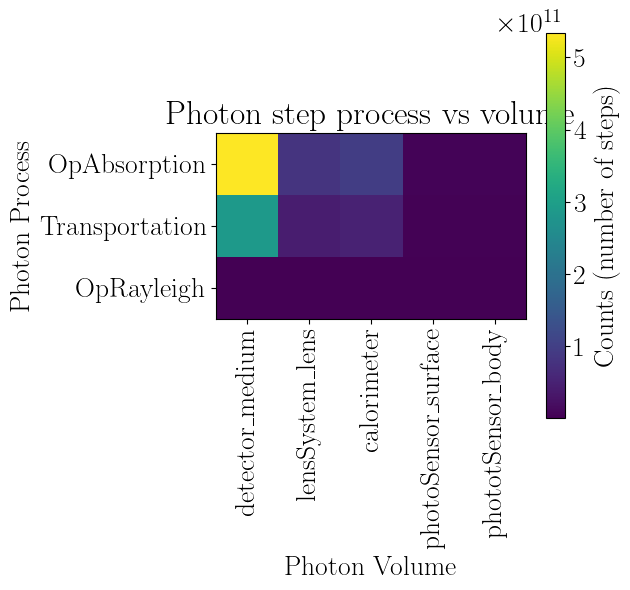

In [17]:
threshold = 0

non_zero_photon_volume = {k: v for k, v in photon_volume_general_count.items() if v >= threshold}
non_zero_photon_process = {k: v for k, v in photon_process_count.items() if v >= threshold}

photon_volume_general_count_values = list(non_zero_photon_volume.values())
photon_process_count_values = list(non_zero_photon_process.values())

convolution_matrix = np.outer(photon_process_count_values, photon_volume_general_count_values)

fig, ax = plt.subplots()
im = ax.imshow(convolution_matrix, cmap='viridis')
fig.colorbar(im, ax=ax, label='Counts (number of steps)')
ax.set_xlabel("Photon Volume")
ax.set_ylabel("Photon Process")
ax.set_title("Photon step process vs volume")
ax.set_yticks(range(len(non_zero_photon_process)))
ax.set_yticklabels(non_zero_photon_process.keys())
ax.set_xticks(range(len(non_zero_photon_volume)))
ax.set_xticklabels(non_zero_photon_volume.keys(), rotation=90)
fig.show()